# Load Eesha data

In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
!pip install transformers
!pip install datasets
!pip install accelerate

In [3]:
import os
from tqdm import tqdm
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import datasets
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import AutoFeatureExtractor, ASTForAudioClassification

In [4]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/final_proj')

Mounted at /content/drive


#Data loading and preprocessing

In [5]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import load_dataset

# Define the genres and their corresponding folders
genres = ['Hip-Hop', 'Rock', 'Pop', 'Folk', 'Experimental', 'Electronic', 'Instrumental', 'International']
data_path = 'fma_filtered'  # Path to your data folder

# Create a list to store the data
data = []

# Loop over each genre folder
for genre in genres:
    genre_folder = os.path.join(data_path, genre)
    
    # Get the audio files in the genre folder
    audio_files = os.listdir(genre_folder)
    
    # Sample 100 files from each genre
    audio_files = audio_files[:100]
    
    # Add the data to the list
    for audio_file in audio_files:
        audio_path = os.path.join(genre_folder, audio_file)
        data.append({
            'input_values': audio_path,
            'labels': genre
        })

# Convert the list to a DataFrame
df = pd.DataFrame(data)

# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=101, stratify=df['labels'])

# Save the train and test sets as CSV files
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)

# Load the dataset using the Hugging Face datasets library
dataset = load_dataset('csv', data_files={'train': 'train.csv', 'validation': 'test.csv'}, cache_dir=False)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-aef7c3e9e58fa3bd/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
# Get the train and validation datasets
train_dataset = dataset['train']
eval_dataset = dataset['validation']

# Preprocess the data
def preprocess_function(examples):
    # Perform your preprocessing steps here
    return examples

train_dataset = train_dataset.map(preprocess_function)
eval_dataset = eval_dataset.map(preprocess_function)

Map:   0%|          | 0/640 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

In [ ]:
# We need to specify the input and output column
input_column = "input_values"
output_column = "labels"

In [8]:
# we need to distinguish the unique labels in our SER dataset
label_list = train_dataset.unique(output_column)
label_list.sort()  # Let's sort it for determinism
num_labels = len(label_list)
print(f"A classification problem with {num_labels} classes:\n {label_list}")

A classification problem with 8 classes:
 ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


In [9]:
from transformers import AutoConfig, ASTConfig, ASTModel, ASTFeatureExtractor

model_name_or_path = 'MIT/ast-finetuned-audioset-10-10-0.4593'
pooling_mode = "mean"

config = AutoConfig.from_pretrained(
    model_name_or_path,
    num_labels=num_labels,
    label2id={label: i for i, label in enumerate(label_list)},
    id2label={i: label for i, label in enumerate(label_list)},
    ignore_mismatched_sizes=True
    # finetuning_task="wav2vec2_clf",
)

config_original = ASTConfig()

model = ASTForAudioClassification(config)
original_model = ASTModel(config_original)

In [10]:
original_model.config

ASTConfig {
  "attention_probs_dropout_prob": 0.0,
  "frequency_stride": 10,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_length": 1024,
  "model_type": "audio-spectrogram-transformer",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_mel_bins": 128,
  "patch_size": 16,
  "qkv_bias": true,
  "time_stride": 10,
  "transformers_version": "4.29.1"
}

In [10]:
model.config

ASTConfig {
  "_name_or_path": "MIT/ast-finetuned-audioset-10-10-0.4593",
  "architectures": [
    "ASTForAudioClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "frequency_stride": 10,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "Electronic",
    "1": "Experimental",
    "2": "Folk",
    "3": "Hip-Hop",
    "4": "Instrumental",
    "5": "International",
    "6": "Pop",
    "7": "Rock"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Electronic": 0,
    "Experimental": 1,
    "Folk": 2,
    "Hip-Hop": 3,
    "Instrumental": 4,
    "International": 5,
    "Pop": 6,
    "Rock": 7
  },
  "layer_norm_eps": 1e-12,
  "max_length": 1024,
  "model_type": "audio-spectrogram-transformer",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_mel_bins": 128,
  "patch_size": 16,
  "qkv_bias": true,
  "time_stride": 10,
  "torch_dtype": "float32",
  "transformers_version": "4.29.1"
}

In [11]:
from transformers import ASTFeatureExtractor

feature_extractor = ASTFeatureExtractor.from_pretrained(model_name_or_path)
target_sampling_rate = feature_extractor.sampling_rate
print(f"The target sampling rate: {target_sampling_rate}")

The target sampling rate: 16000


In [12]:
train_dataset

Dataset({
    features: ['input_values', 'labels'],
    num_rows: 640
})

In [13]:
def label_to_id(label, label_list):
    if len(label_list) > 0:
        return label_list.index(label) if label in label_list else -1
    return label

from datasets import Dataset

# eesha's

def load_preprocessed(example):
    speech_path = os.path.join("preprocessed_tensors_full/", example['input_values'].split("/")[-1] + '.pt')
    if os.path.exists(speech_path):
        speech = torch.load(speech_path).squeeze(0)[:479626] # max 
        example['input_values'] = torch.tensor(speech)  # ensure that 'speech' is a tensor
        example['labels'] = label_to_id(example['labels'], label_list)
        example['file_exists'] = True
    else:
        example['file_exists'] = False
    return example


In [14]:
exam = torch.load("preprocessed_tensors_full/0048_International.mp3.pt")
exam.squeeze(0).shape

torch.Size([480000])

In [15]:
def check_file_exists(example):
    speech_path = os.path.join("preprocessed_tensors_full/", example['input_values'].split("/")[-1] + '.pt')
    return os.path.exists(speech_path)

# Find the indices of examples that you want to keep
train_indices = [i for i, example in enumerate(train_dataset) if check_file_exists(example)]
eval_indices = [i for i, example in enumerate(eval_dataset) if check_file_exists(example)]

# Select only the examples with those indices
train_dataset = train_dataset.select(train_indices)
eval_dataset = eval_dataset.select(eval_indices)

In [16]:
# Now apply your map function only on the selected examples
train_dataset = train_dataset.map(load_preprocessed)
eval_dataset = eval_dataset.map(load_preprocessed)

Map:   0%|          | 0/589 [00:00<?, ? examples/s]

<ipython-input-13-e0331df2be2d>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  example['input_values'] = torch.tensor(speech)  # ensure that 'speech' is a tensor


Map:   0%|          | 0/144 [00:00<?, ? examples/s]

In [17]:
train_dataset.set_format(type='torch', columns=['input_values', 'labels'])
eval_dataset.set_format(type='torch', columns=['input_values', 'labels'])

In [32]:
train_dataset['input_values'][0].shape

torch.Size([479626])

In [34]:
train_dataset = train_dataset.remove_columns("file_exists")
eval_dataset = eval_dataset.remove_columns("file_exists")

In [104]:
def preprocess_ast(examples):
  # audio_arrays = [x for x in examples["input_values"]]
  audio_arrays = []
  for x in examples['input_values']:
    np_x = x.numpy() # without this the fn will throw sequence in array typeerror
    audio_arrays.append(np_x)
  inputs = feature_extractor(
        audio_arrays, 
        sampling_rate=16000, 
        truncation=True, 
    )
  return inputs

In [110]:
encoded_train_dataset = train_dataset.map(preprocess_ast, batched=True)
encoded_eval_dataset = eval_dataset.map(preprocess_ast, batched=True)

In [33]:
# inspect input
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

inputs = feature_extractor(train_dataset['input_values'][0], sampling_rate=16000, padding='max_length')
input_values = torch.Tensor(inputs.input_values).to(device)
input_values.shape

<ipython-input-33-b41f540ea3eb>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  input_values = torch.Tensor(inputs.input_values).to(device)


torch.Size([1, 1024, 128])

# Define Model / Train Set-up

In [19]:
from datasets import load_dataset, load_metric
metric = load_metric("accuracy")

<ipython-input-19-2081cfe081e3>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [20]:
model_checkpoint = "MIT/ast-finetuned-audioset-10-10-0.4593"
batch_size = 32

In [25]:
from transformers import ASTForAudioClassification
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer

# # this does not work. throws dim error for input
# ex = ASTForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

# num_labels = len(label_list)
ex_2 = AutoModelForAudioClassification.from_pretrained(
    model_checkpoint, 
    num_labels=num_labels,
    label2id={label: i for i, label in enumerate(label_list)},
    id2label={i: label for i, label in enumerate(label_list)},
    ignore_mismatched_sizes=True
    # hidden_dropout = 0.1,
    # activation_dropout = 0.1,
    # attention_dropout = 0.1,
    # feat_proj_dropout = 0.0,
    # feat_quantizer_dropout = 0.0,
    # final_dropout = 0.1
)

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
# Eesha Code START

from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer

# num_labels = len(label_list)
# model = AutoModelForAudioClassification.from_pretrained(
#     model_checkpoint, 
#     num_labels=num_labels,
#     label2id={label: i for i, label in enumerate(label_list)},
#     id2label={i: label for i, label in enumerate(label_list)},
#     hidden_dropout = 0.1,
#     activation_dropout = 0.1,
#     attention_dropout = 0.1,
#     feat_proj_dropout = 0.0,
#     feat_quantizer_dropout = 0.0,
#     final_dropout = 0.1
# )

# Eesha code END

In [26]:
args = TrainingArguments(
    output_dir="ast-jl",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=4,
    num_train_epochs=20,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

In [27]:
import numpy as np

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

# let's finally train!

In [115]:
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer

trainer = Trainer(
    ex_2, #
    args,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_eval_dataset,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)

In [116]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.637600,1.294635,0.604167
2,0.998600,1.179223,0.645833
3,0.477800,1.071424,0.694444
4,0.193500,1.144084,0.666667
5,0.047000,1.264318,0.701389
6,0.008200,1.438217,0.687500
7,0.001500,1.504931,0.715278
8,0.000500,1.562733,0.694444
9,0.000400,1.577474,0.694444
10,0.000300,1.597993,0.701389


TrainOutput(global_step=740, training_loss=0.18176794076586972, metrics={'train_runtime': 6060.12, 'train_samples_per_second': 1.944, 'train_steps_per_second': 0.122, 'total_flos': 7.985245988270899e+17, 'train_loss': 0.18176794076586972, 'epoch': 20.0})

In [117]:
trainer.save_model("ast-jl-1")

In [118]:
evaluation_metrics = trainer.evaluate()

In [119]:
evaluation_metrics

{'eval_loss': 1.5049309730529785,
 'eval_accuracy': 0.7152777777777778,
 'eval_runtime': 20.8628,
 'eval_samples_per_second': 6.902,
 'eval_steps_per_second': 1.726,
 'epoch': 20.0}

In [120]:
predictions = trainer.predict(encoded_eval_dataset).predictions
predictions = np.argmax(predictions, axis=1)
labels = encoded_eval_dataset["labels"]

In [121]:
from sklearn.metrics import confusion_matrix

# Print classification report
report = classification_report(labels, predictions)
print(report)

# Compute the confusion matrix
cm = confusion_matrix(labels, predictions)

              precision    recall  f1-score   support

           0       0.62      0.83      0.71        18
           1       0.77      0.53      0.62        19
           2       0.75      0.71      0.73        17
           3       0.76      0.76      0.76        17
           4       0.71      0.83      0.77        18
           5       0.77      0.94      0.85        18
           6       0.64      0.39      0.48        18
           7       0.70      0.74      0.72        19

    accuracy                           0.72       144
   macro avg       0.72      0.72      0.71       144
weighted avg       0.72      0.72      0.71       144



In [135]:
cm

array([[15,  0,  0,  0,  2,  0,  1,  0],
       [ 0, 10,  1,  1,  1,  4,  1,  1],
       [ 1,  0, 12,  1,  0,  1,  0,  2],
       [ 3,  1,  0, 13,  0,  0,  0,  0],
       [ 0,  0,  1,  1, 15,  0,  0,  1],
       [ 0,  0,  1,  0,  0, 17,  0,  0],
       [ 2,  2,  1,  1,  3,  0,  7,  2],
       [ 3,  0,  0,  0,  0,  0,  2, 14]])

### Graphing

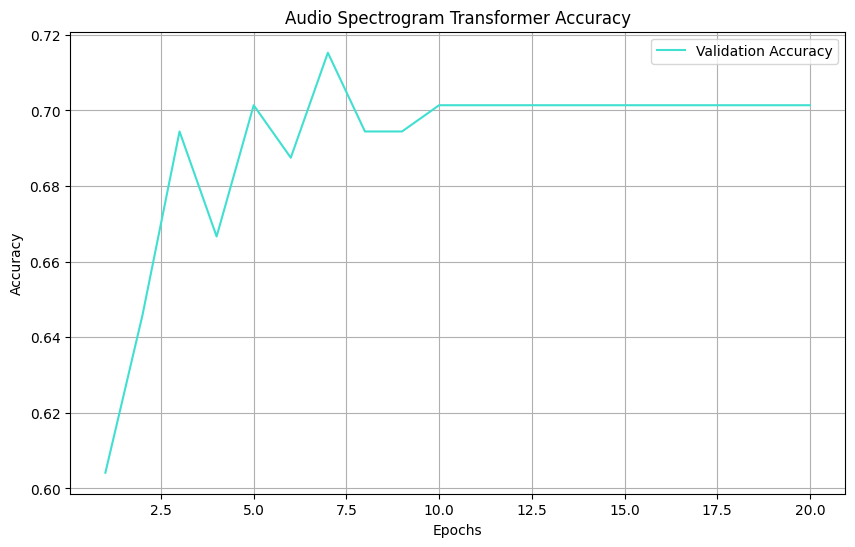

In [127]:
import matplotlib.pyplot as plt

# Your data
epochs = list(range(1, 21))
accuracy = [0.604167, 0.645833, 0.694444, 0.666667, 0.701389, 0.687500, 0.715278, 0.694444, 0.694444, 0.701389, 0.701389, 0.701389, 0.701389, 0.701389, 0.701389, 0.701389, 0.701389, 0.701389, 0.701389, 0.701389]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy, color='turquoise', label='Validation Accuracy', linestyle='-')
plt.title('Audio Spectrogram Transformer Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

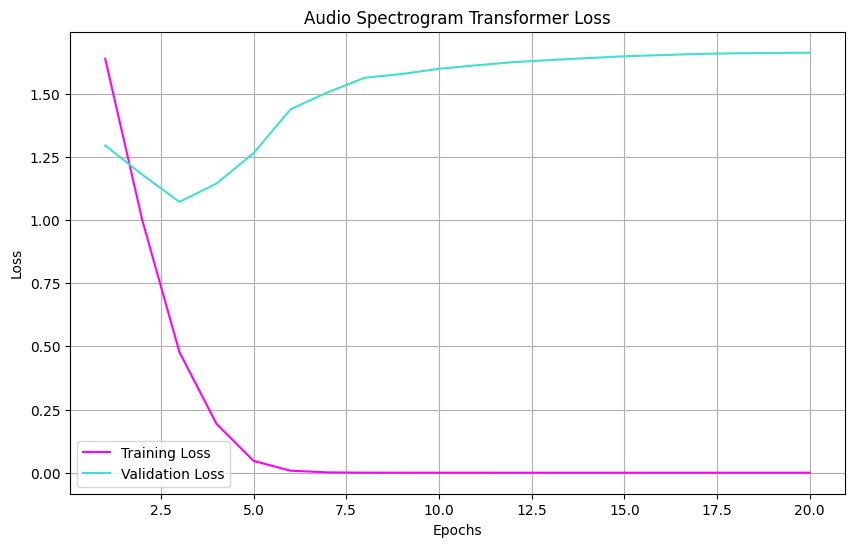

In [128]:
# Your data
epochs = list(range(1, 21))

training_loss = [1.637600, 0.998600, 0.477800, 0.193500, 0.047000, 0.008200, 0.001500, 0.000500, 0.000400, 0.000300, 0.000300, 0.000200, 0.000200, 0.000200, 0.000200, 0.000200, 0.000200, 0.000200, 0.000200, 0.000200]
validation_loss = [1.294635, 1.179223, 1.071424, 1.144084, 1.264318, 1.438217, 1.504931, 1.562733, 1.577474, 1.597993, 1.611788, 1.624212, 1.632573, 1.640300, 1.647381, 1.652196, 1.656819, 1.659274, 1.660684, 1.661571]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, color='magenta', label='Training Loss', linestyle='-')
plt.plot(epochs, validation_loss, color='turquoise', label='Validation Loss', linestyle='-')
plt.title('Audio Spectrogram Transformer Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

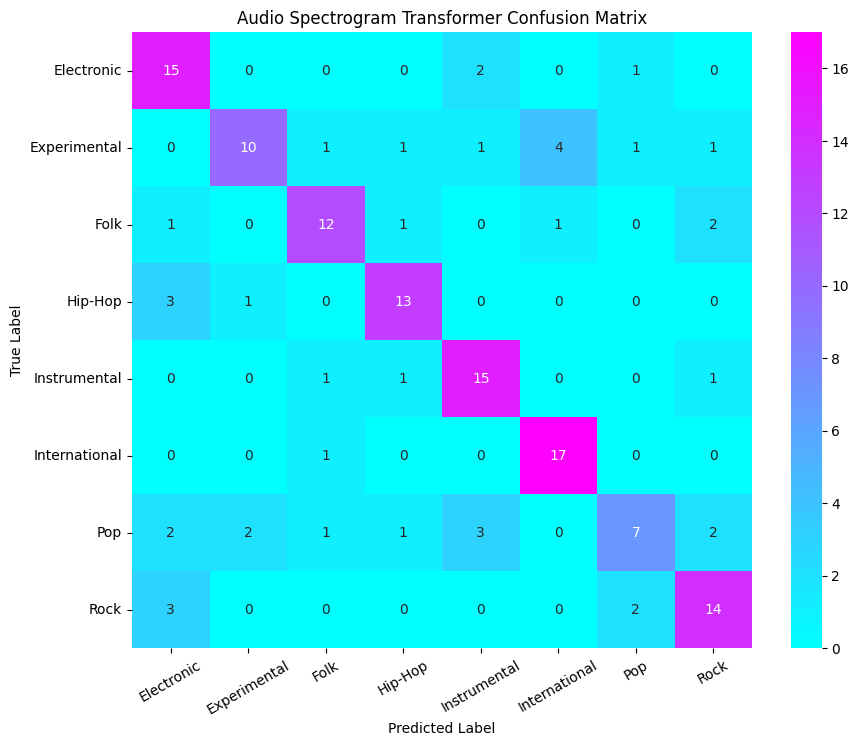

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrix = [
    [15,  0,  0,  0,  2,  0,  1,  0],
       [ 0, 10,  1,  1,  1,  4,  1,  1],
       [ 1,  0, 12,  1,  0,  1,  0,  2],
       [ 3,  1,  0, 13,  0,  0,  0,  0],
       [ 0,  0,  1,  1, 15,  0,  0,  1],
       [ 0,  0,  1,  0,  0, 17,  0,  0],
       [ 2,  2,  1,  1,  3,  0,  7,  2],
       [ 3,  0,  0,  0,  0,  0,  2, 14]
]

genres = ["Electronic", "Experimental", "Folk", "Hip-Hop", "Instrumental", "International", "Pop", "Rock"]

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="cool", xticklabels=genres, yticklabels=genres)
plt.xticks(rotation=30)

plt.title("Audio Spectrogram Transformer Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
with open('graphs/ast_1_confusion.png', 'w') as f:
  f.write('content')

In [124]:
import json

with open("metrics/evaluation_metrics_ast_1.json", "w") as outfile:
    json.dump(evaluation_metrics, outfile)

with open('metrics/classification_report_ast_1.txt', 'w') as f:
    f.write(report)

# Save confusion matrix
np.savetxt("metrics/confusion_matrix_ast_1.csv", cm, delimiter=",")

### Make spectrograms

In [137]:
train_dataset['input_values'][0]

tensor([-0.0061, -0.0061, -0.0061,  ...,  0.1763,  0.2395,  0.1180])

In [153]:
label_occurrences = {}
for example in encoded_train_dataset:
    label = example['labels']
    if label not in label_occurrences:
        label_occurrences[label] = example
    else:
        break

In [155]:
label_occurrences

{tensor(0): {'input_values': tensor([[ 0.5309,  0.1745,  0.5513,  ...,  0.7953,  0.7608,  0.7948],
          [ 0.7376,  0.3853,  0.7621,  ...,  1.0032,  0.9984,  0.8774],
          [ 0.8227,  0.4607,  0.8375,  ...,  0.7883,  0.7078,  0.7419],
          ...,
          [-0.2355, -0.2558,  0.1210,  ..., -0.3731, -0.3259, -0.2857],
          [-0.1162, -0.4609, -0.0840,  ..., -0.2831, -0.3543, -0.4302],
          [-0.3355, -0.2746,  0.1022,  ..., -0.4847, -0.4934, -0.5713]]),
  'labels': tensor(0)},
 tensor(3): {'input_values': tensor([[0.5496, 0.2447, 0.6215,  ..., 0.8604, 0.8561, 0.8398],
          [0.5324, 0.1948, 0.5716,  ..., 0.9954, 1.0004, 0.9832],
          [0.2193, 0.1208, 0.4976,  ..., 0.8780, 0.8695, 0.8279],
          ...,
          [0.7739, 0.3861, 0.7629,  ..., 0.6013, 0.5970, 0.6127],
          [0.7841, 0.4125, 0.7893,  ..., 0.6119, 0.6644, 0.6771],
          [0.6745, 0.2867, 0.6636,  ..., 0.5591, 0.6087, 0.5593]]),
  'labels': tensor(3)},
 tensor(5): {'input_values': tensor(

In [187]:
spectrogram_hiphop = get_spectrogram(train_dataset['input_values'][0], hop_len = int(16000 * 0.008))

ax1.imshow(torch.log(spectrogram_hiphop).numpy(), aspect='auto')
ax1.set_title("Hip Hop", {'fontsize':20, 'fontweight':'bold'})

Text(0.5, 1.0, 'Hip Hop')

In [190]:
# Convert to spectrogram and display

import torchaudio.transforms as T

def get_spectrogram(
    waveform,
    n_fft = 2048,
    win_len = None,
    hop_len = 16000 * 0.008,
    power = 2.0,
    ):
  
    spectrogram = T.Spectrogram(
        n_fft=n_fft,
        win_length=win_len,
        hop_length=hop_len,
        center=True,
        pad_mode="reflect",
        power=power,
    )
    return spectrogram(waveform)

genres = ['Hip-Hop', 'Rock', 'Pop', 'Folk', 'Experimental', 'Electronic', 'Instrumental', 'International']

spectrogram_hiphop = get_spectrogram(train_dataset['input_values'][0], hop_len = int(16000 * 0.008))
spectrogram_rock = get_spectrogram(train_dataset['input_values'][3], hop_len = int(16000 * 0.008))
spectrogram_pop = get_spectrogram(train_dataset['input_values'][8], hop_len = int(16000 * 0.008))
spectrogram_folk = get_spectrogram(train_dataset['input_values'][1], hop_len = int(16000 * 0.008))
spectrogram_experimental = get_spectrogram(train_dataset['input_values'][17], hop_len = int(16000 * 0.008))
spectrogram_electronic = get_spectrogram(train_dataset['input_values'][2], hop_len = int(16000 * 0.008))
spectrogram_instrumental = get_spectrogram(train_dataset['input_values'][9], hop_len = int(16000 * 0.008))
spectrogram_international = get_spectrogram(train_dataset['input_values'][4], hop_len = int(16000 * 0.008))

# spectrogram_yes_loud = get_spectrogram(audio_yes_loud[0], hop_len = int(sr_yes_loud * 0.008))
# spectrogram_yes_quiet = get_spectrogram(audio_yes_quiet[0], hop_len = int(sr_yes_quiet * 0.008))
# spectrogram_no_loud = get_spectrogram(audio_no_loud[0], hop_len = int(sr_no_loud * 0.008))
# spectrogram_no_quiet = get_spectrogram(audio_no_quiet[0], hop_len = int(sr_no_quiet * 0.008))

# Plot the figures
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(nrows=2, ncols=4)

ax1.imshow(torch.log(spectrogram_hiphop).numpy(), aspect='auto')
ax1.set_title("Hip Hop", {'fontsize':20, 'fontweight':'bold'})

ax2.imshow(torch.log(spectrogram_rock).numpy(), aspect='auto')
ax2.set_title("Rock", {'fontsize':20, 'fontweight':'bold'})

ax3.imshow(torch.log(spectrogram_pop).numpy(), aspect='auto')
ax3.set_title("Pop", {'fontsize':20, 'fontweight':'bold'})

ax4.imshow(torch.log(spectrogram_folk).numpy(), aspect='auto')
ax4.set_title("Folk", {'fontsize':20, 'fontweight':'bold'})

ax5.imshow(torch.log(spectrogram_experimental).numpy(), aspect='auto')
ax5.set_title("Experimental", {'fontsize':20, 'fontweight':'bold'})

ax6.imshow(torch.log(spectrogram_electronic).numpy(), aspect='auto')
ax6.set_title("Electronic", {'fontsize':20, 'fontweight':'bold'})

ax7.imshow(torch.log(spectrogram_instrumental).numpy(), aspect='auto')
ax7.set_title("Instrumental", {'fontsize':20, 'fontweight':'bold'})

ax8.imshow(torch.log(spectrogram_international).numpy(), aspect='auto')
ax8.set_title("International", {'fontsize':20, 'fontweight':'bold'})

fig.set_size_inches(22,12)
fig.text(0.5, 0.06, 'Time', {'fontsize':20, 'fontweight':'bold'}, ha='center');
fig.text(0.08, 0.5, 'Hz', {'fontsize':20, 'fontweight':'bold'}, va='center', rotation='vertical');



Output hidden; open in https://colab.research.google.com to view.

### Attempt with Github tutorial (most likely to work)

https://github.com/NielsRogge/Transformers-Tutorials/blob/master/AST/Inference_with_the_Audio_Spectogram_Transformer_to_classify_audio.ipynb



In [ ]:
from torch.utils.data import Dataset, DataLoader

class CustomAudioDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.file_list = []
        for genre in os.listdir(self.data_dir):
            genre_dir = os.path.join(self.data_dir, genre)
            for file_name in os.listdir(genre_dir):
                file_path = os.path.join(genre_dir, file_name)
                self.file_list.append((file_path, genre))

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path, genre = self.file_list[idx]
        waveform, sample_rate = torchaudio.load(file_path)
        return waveform, sample_rate, genre

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# from chat gpt

import torch.nn.functional as F

def collate_fn_padd(batch):
    waveforms, sample_rates, genres = zip(*batch)

    # Find the maximum length
    max_length = max(waveform.size(1) for waveform in waveforms)
    max_length_0 = max(waveform.size(0) for waveform in waveforms)

    # Pad waveforms to the maximum length
    padded_waveforms = []
    for waveform in waveforms:
        padded_waveform = F.pad(waveform, pad=(max_length_0 - waveform.size(0), max_length - waveform.size(1)))
        padded_waveforms.append(padded_waveform)

    # Convert the padded waveforms to a tensor
    padded_waveforms = torch.stack(padded_waveforms)

    return padded_waveforms, sample_rates, genres

In [ ]:
dataset = CustomAudioDataset('genre_sorted_mp3s')
dataloader = DataLoader(dataset, batch_size=3, shuffle=True, collate_fn = collate_fn_padd)

In [ ]:
for batch_idx, (waveform, sample_rate, genre) in enumerate(dataloader):
    waveform = waveform.squeeze().numpy()
    print(f"Batch {batch_idx}: waveform shape={waveform.shape}, sample_rate={sample_rate}, genre={genre}")

Batch 0: waveform shape=(3, 2, 1323119), sample_rate=(44100, 44100, 44100), genre=('Instrumental', 'International', 'Rock')
Batch 1: waveform shape=(3, 2, 1321967), sample_rate=(44100, 44100, 44100), genre=('Electronic', 'Pop', 'Instrumental')
Batch 2: waveform shape=(3, 2, 1323119), sample_rate=(44100, 44100, 44100), genre=('Experimental', 'Instrumental', 'International')
Batch 3: waveform shape=(3, 2, 1323119), sample_rate=(44100, 44100, 44100), genre=('Pop', 'Rock', 'Instrumental')
Batch 4: waveform shape=(3, 2, 1323648), sample_rate=(44100, 44100, 44100), genre=('Rock', 'Rock', 'Rock')
Batch 5: waveform shape=(3, 2, 1323119), sample_rate=(44100, 44100, 44100), genre=('Instrumental', 'Electronic', 'Hip-Hop')
Batch 6: waveform shape=(3, 2, 1323119), sample_rate=(44100, 44100, 44100), genre=('Electronic', 'Pop', 'Electronic')
Batch 7: waveform shape=(3, 2, 1323119), sample_rate=(44100, 44100, 44100), genre=('Hip-Hop', 'Pop', 'Experimental')
Batch 8: waveform shape=(3, 2, 1323119), sam

RuntimeError: ignored

### Previous attempt but was getting 0.0 accuracy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from transformers import AutoFeatureExtractor, ASTForAudioClassification
from datasets import load_dataset
import torch
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = load_dataset('genre_sorted_mp3s', "clean", split="train", num_proc=8)
sampling_rate = dataset.features["audio"].sampling_rate
train_testvalid = dataset.train_test_split(test_size=0.1)

feature_extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
model = ASTForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593").to(device)

# Get test set
test_dataset = train_testvalid['test']
test_samples = len(test_dataset)

# Evaluate on test set
model.eval()
correct = 0

with torch.no_grad():
    for sample in test_dataset:
        inputs = feature_extractor(sample["audio"]["array"], sampling_rate=sampling_rate, return_tensors="pt").to(device)
        # labels = torch.tensor([model.config.label2id[sample["label"]]])
        labels = torch.tensor(sample["label"]).to(device)
        inputs["labels"] = labels
        outputs = model(**inputs)
        predicted_class_ids = torch.argmax(outputs.logits, dim=-1)
        correct += (predicted_class_ids == labels).sum().item()

accuracy = correct / test_samples
print(f"Accuracy on test set: {accuracy:.2f}")

Resolving data files:   0%|          | 0/8000 [00:00<?, ?it/s]

Process ForkPoolWorker-39:


KeyboardInterrupt: ignored